In [1]:
# Core
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# import xgboost as xgb
import lightgbm as lgb
import sklearn.svm as svm
%matplotlib inline
import xgboost as xgb


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score

import time

from yellowbrick.features import rank2d, RadViz, Rank2D
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
# Save to df
train_data = pd.read_csv('../input/playground-series-s4e1/train.csv')
test_data = pd.read_csv('../input/playground-series-s4e1/test.csv')
original_data = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')

# Shape and preview
print('Train set shape:', train_data.shape)
print('Test set shape:', test_data.shape)
print('Original set shape', original_data.shape)
original_data.head()

Train set shape: (165034, 14)
Test set shape: (110023, 13)
Original set shape (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Data analysis and engineering

In [3]:
print('TRAIN SET MISSING VALUES:')
print(train_data.isnull().sum())
print('')
print('TEST SET MISSING VALUES:')
print(test_data.isnull().sum())

#original data
print('ORIGINAL SET MISSING VALUES:')
print(original_data.isnull().sum())

TRAIN SET MISSING VALUES:
id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

TEST SET MISSING VALUES:
id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64
ORIGINAL SET MISSING VALUES:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [4]:
train_data = pd.concat([train_data, original_data], axis=0, ignore_index=True)
train = train_data.drop(['id','RowNumber'], axis=1)
test = test_data.drop('id', axis=1)
train.shape

(175034, 13)

In [5]:
train.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.750340e+05,175034.000000,175034.000000,175034.000000,175034.000000,175034.00000,175034.000000,175034.00000,175034.000000,175034.000000
mean,1.569194e+07,656.115835,38.171360,5.019922,56678.299368,1.55307,0.751185,0.49876,111861.556577,0.211148
std,7.142890e+04,81.151171,8.969552,2.811136,62982.565768,0.54921,0.432327,0.50000,50815.382991,0.408124
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.00000,0.000000,0.00000,11.580000,0.000000
25%,1.563288e+07,597.000000,32.000000,3.000000,0.000000,1.00000,1.000000,0.00000,73192.370000,0.000000
50%,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.00000,1.000000,0.00000,116969.730000,0.000000
75%,1.575666e+07,710.000000,42.000000,7.000000,120729.297500,2.00000,1.000000,1.00000,154767.340000,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.00000,1.000000,1.00000,199992.480000,1.000000


In [6]:
# Remove duplicated rows
print(train.duplicated().sum())
train = train.drop_duplicates()
train.shape

0


(175034, 13)

In [7]:
train.dtypes

CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

In [8]:
print(train.columns)

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')


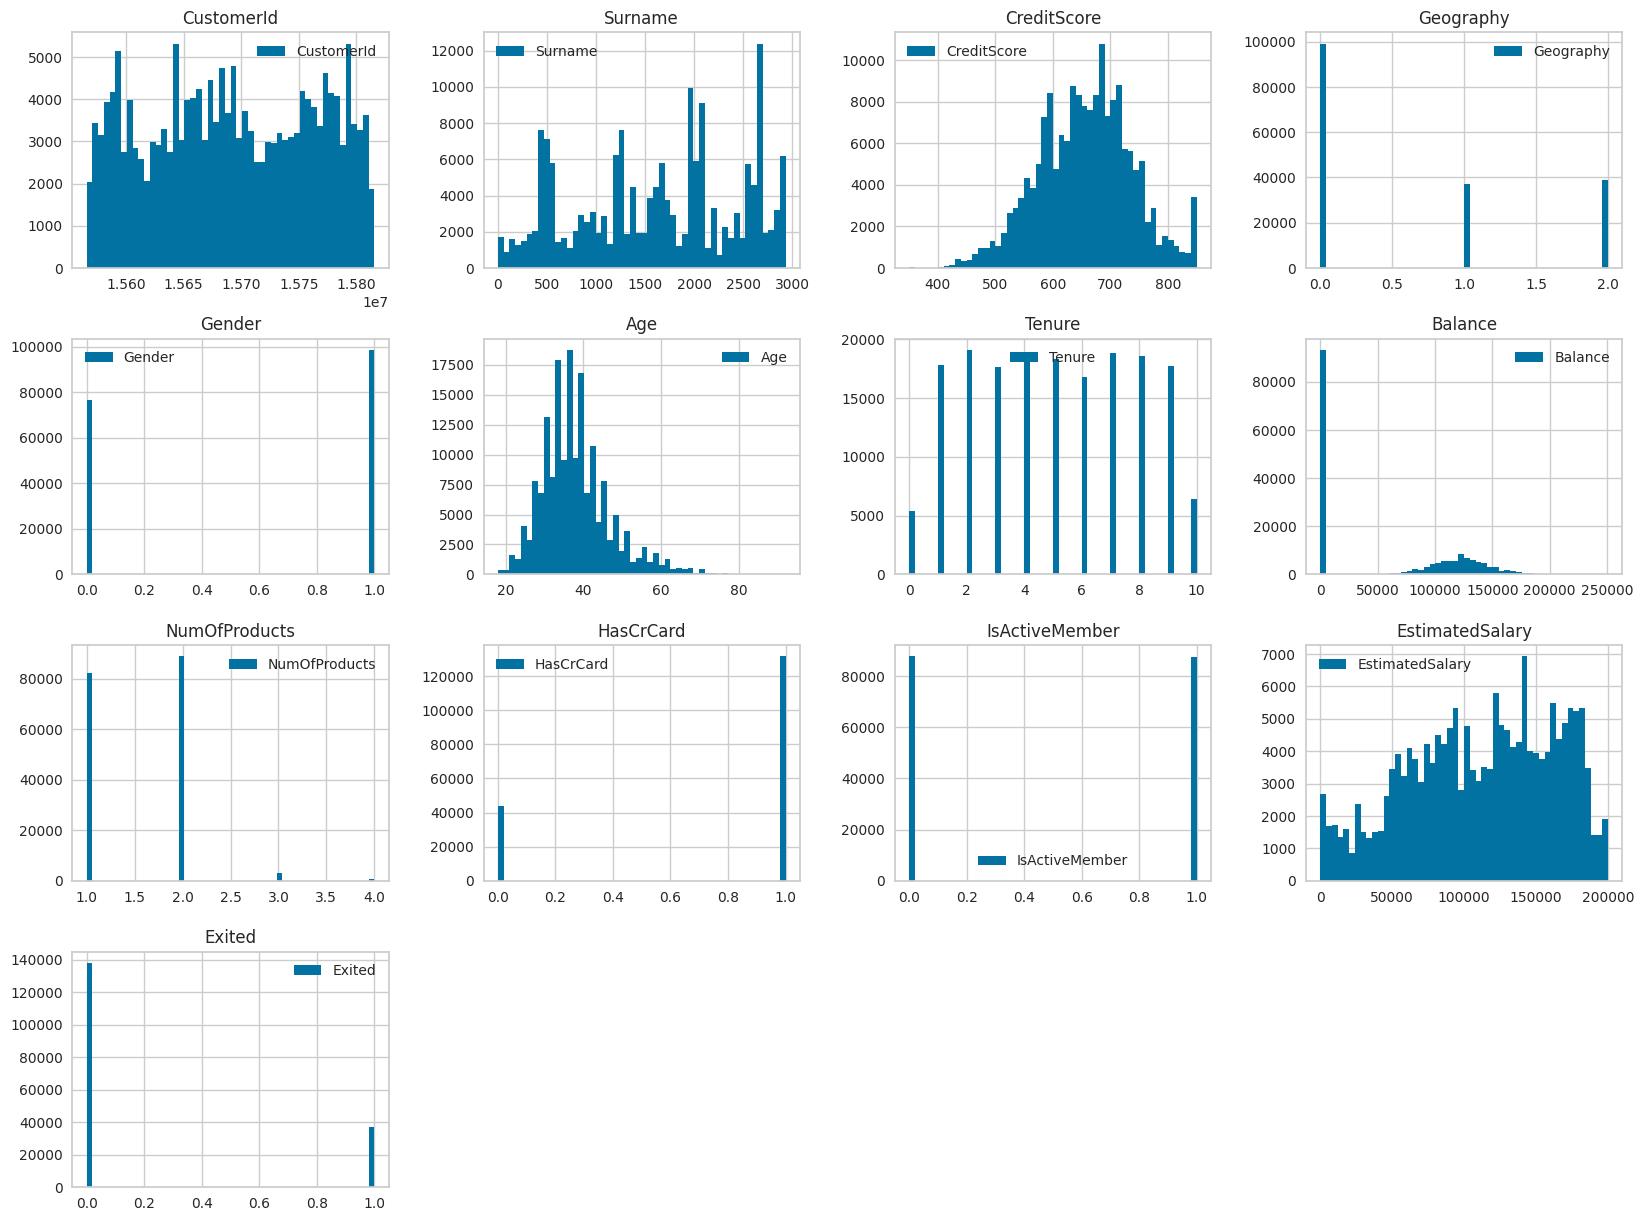

In [9]:
# Plotting every feature on the graph 

from sklearn.preprocessing import LabelEncoder
# Create a deep copy of train and name it data
data = train.copy()

label_encoder = LabelEncoder()
data['Geography'] = label_encoder.fit_transform(data['Geography'])
data['Gender'] = label_encoder.fit_transform(data['Gender'])
data['Surname'] = label_encoder.fit_transform(data['Surname'])

data.hist(bins=50, figsize=(20,15), legend = True)
plt.show()

In [10]:
data.nunique() #Uniqueness of the feature

CustomerId         23421
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   72
Tenure                11
Balance            30239
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary    55581
Exited                 2
dtype: int64

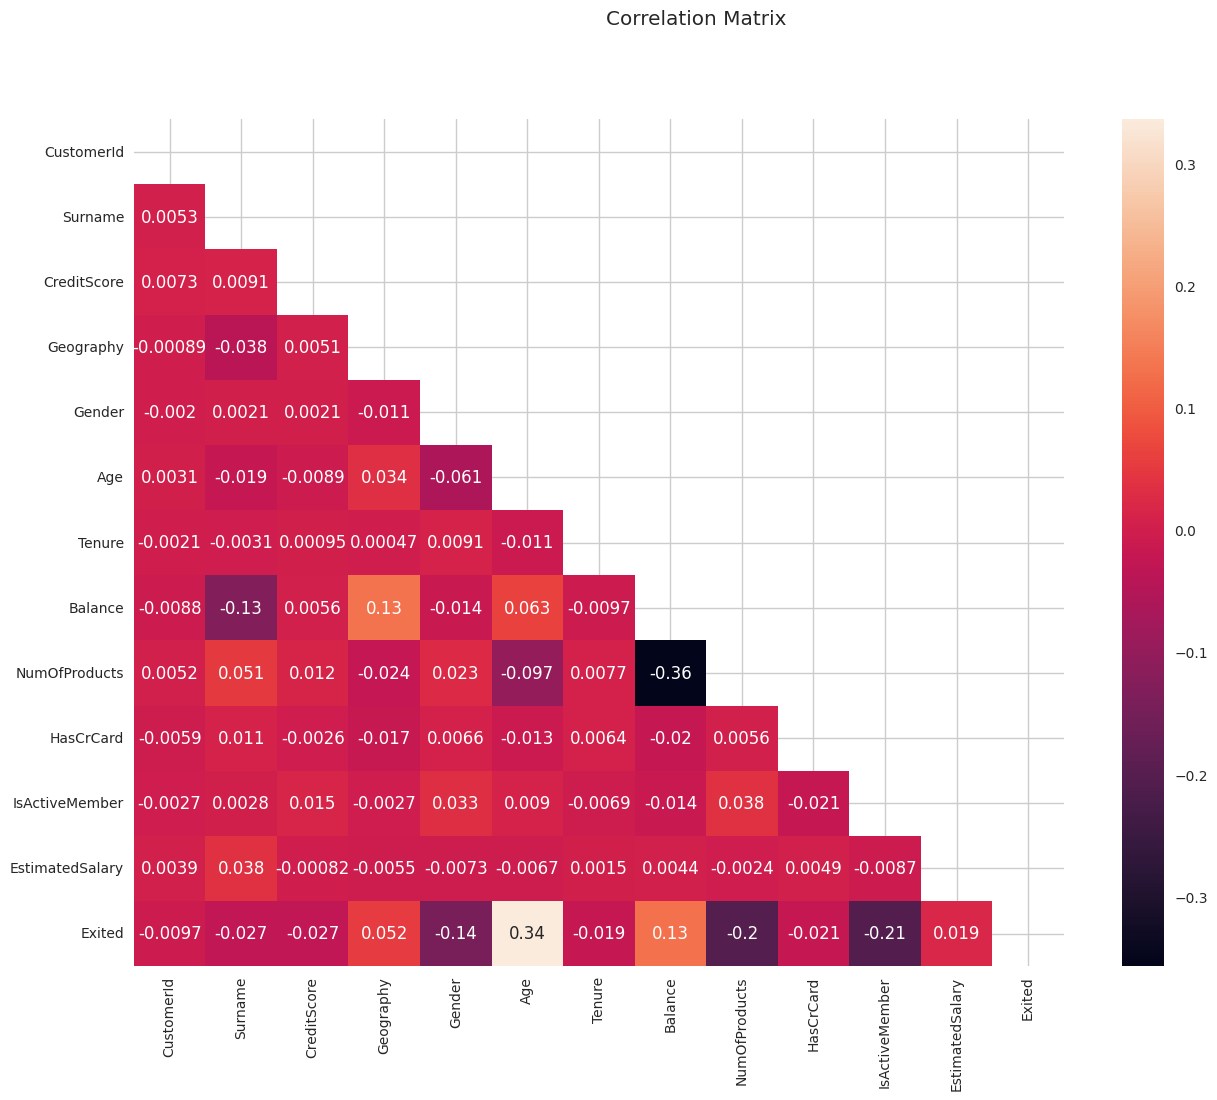

In [11]:
# df4 = data[['CustomerId', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary', 
#        'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']].copy()

corr_matrix=data.corr()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

f,ax=plt.subplots(figsize=(15,11))
sns.heatmap(corr_matrix, mask=mask, annot=True)
plt.suptitle('Correlation Matrix')
plt.show()

In [12]:
# # # Get list of categorical variables
# # s = (train.dtypes == 'object')
# # object_cols = list(s[s].index)

# # print("Categorical variables:")
# # print(object_cols)

# # Threshold to distinguish continuous and categorical
# threshold = 9

# continuous_vars = unique_counts[unique_counts > threshold].index.tolist()
# categorical_vars = unique_counts[unique_counts <= threshold].index.tolist()

# # Removing the 'outcome' from categorical since it's our target variable
# if 'outcome' in categorical_vars:
#     categorical_vars.remove('outcome')
# if 'id' in continuous_vars:
#     continuous_vars.remove('id')

# print(f"Categorical Variables: {categorical_vars}")
# print(f"Continousl/Numerical Variables: {continuous_vars}")

In [13]:
def geo_gender_tr(df) : 
    df['Geo_Gender'] = df['Geography'].astype('str') + '_' + df['Gender'].astype('str')
    return df

def cred_score_tr(df) : 
    df['Credit_Score_Range'] = pd.cut(df['CreditScore'], bins=[0, 300, 600, 700, 800, 900], labels=['0-300', '300-600', '600-700', '700-800', '900+'])
    return df

def age_tr(df) : 
    df['Age_Category'] = pd.cut(df['Age'], bins=[18, 30, 40, 50, 60, 100], labels=['18-30', '30-40', '40-50', '50-60', '60+'],include_lowest = True)
    return df


def is_young(df):
    df['IS_Young'] = pd.cut(df['Age'], bins = [18, 35, 100], labels = [0, 1 ], include_lowest = True)
    return df

def gen_active_tr(df) : 
    df['IsActive_Gender'] = df['IsActiveMember'].astype('str') + '_' + df['Gender'].astype('str')
    return df

def gen_no_tr(df) : 
    df['No_Gender'] = df['NumOfProducts'].astype('str') + '_' + df['Gender'].astype('str')
    return df

def acc_sal_tr(df):
    df['Balance_Salary_Ratio'] = df['Balance'] / df['EstimatedSalary']
    return df

def age_sal_tr(df):
    df['Balance_Age_Ratio'] = df['Balance'] / df['Age']
    return df

def age_acc_tr(df):
    df['Salary_Age_ratio'] = df['EstimatedSalary'] / df['Age']
    return df

def tp_gender_tr(df) : 
    df['Tp_Gender'] = df['NumOfProducts'].astype('str') + df['Gender'].astype('str')
    return df

def meme(data):
    data['Mem__no__Products'] = data['NumOfProducts'] * data['IsActiveMember']
    return data

def credit_tenure(data):
    data['Credit_per_tenure'] = data['Tenure'] / data['CreditScore']
    return data

def salary_tenure(data):
    data['Credit_per_tenure'] = data['Tenure'] / data['EstimatedSalary']
    return data

In [14]:
data = geo_gender_tr(data)
data = cred_score_tr(data)
data = age_tr(data)
data = is_young(data)
data = gen_active_tr(data)
data = gen_no_tr(data)
data = acc_sal_tr(data)
data = age_sal_tr(data)
data = age_acc_tr(data)
data = tp_gender_tr(data)
data = meme(data)
data = credit_tenure(data)
data = salary_tenure(data)

data['Geo_Gender'] = label_encoder.fit_transform(data['Geo_Gender'])
data['Credit_Score_Range'] = label_encoder.fit_transform(data['Credit_Score_Range'])
data['Age_Category'] = label_encoder.fit_transform(data['Age_Category'])
data['IsActive_Gender'] = label_encoder.fit_transform(data['IsActive_Gender'])
data['No_Gender'] = label_encoder.fit_transform(data['No_Gender'])
data['Tp_Gender'] = label_encoder.fit_transform(data['Tp_Gender'])

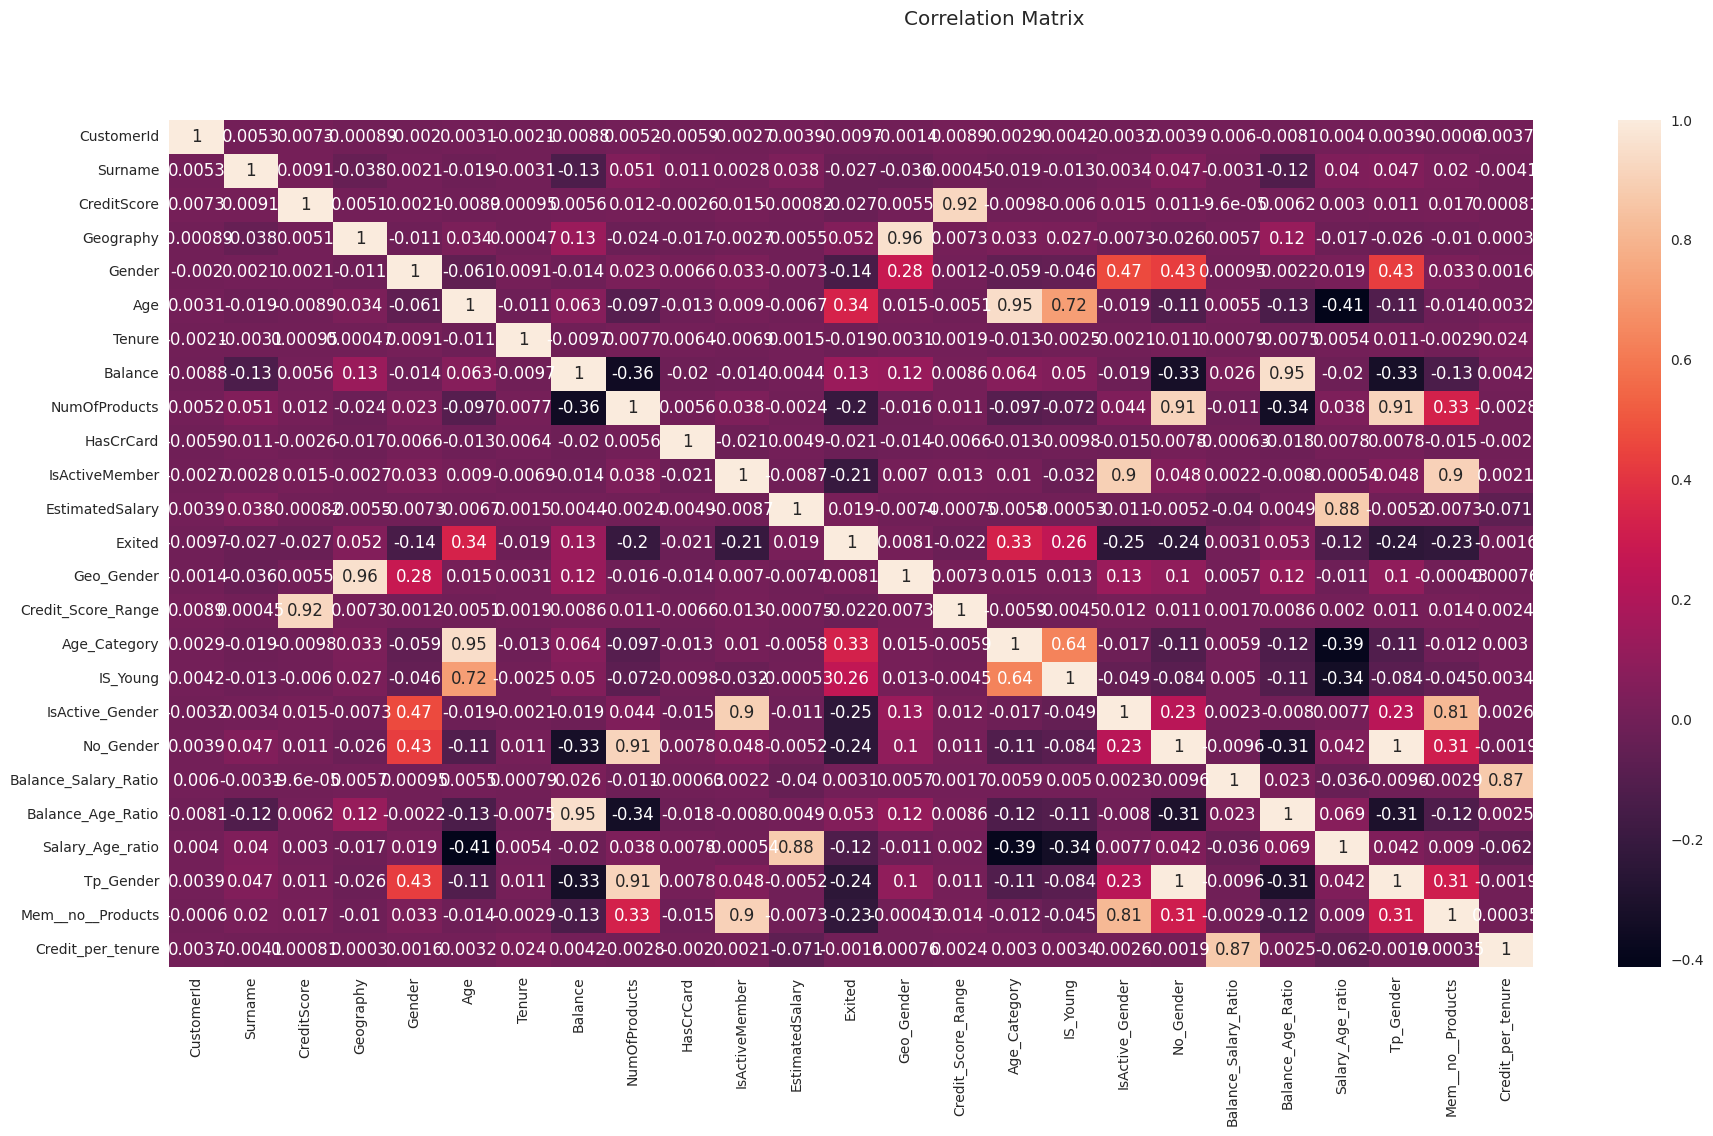

In [15]:
corr_matrix=data.corr()


f,ax=plt.subplots(figsize=(22,11))
sns.heatmap(corr_matrix, annot=True)
plt.suptitle('Correlation Matrix')
plt.show()

In [16]:
# # dropping surname and customerid
# train = train.drop(['Surname','CustomerId'], axis=1)
# test = test.drop(['Surname','CustomerId'],axis=1)

In [17]:
label_encoder = LabelEncoder()

train['Surname'] = label_encoder.fit_transform(train['Surname'])
test['Surname'] = label_encoder.transform(test['Surname'])

# New Feature 
train = age_tr(train)
train = is_young(train)
train = gen_active_tr(train)
train = age_sal_tr(train)
train = age_acc_tr(train)
train = tp_gender_tr(train)
train = meme(train)

test = age_tr(test)
test = is_young(test)
test = gen_active_tr(test)
test = age_sal_tr(test)
test = age_acc_tr(test)
test = tp_gender_tr(test)
test = meme(test)

In [18]:
train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age_Category,IS_Young,IsActive_Gender,Balance_Age_Ratio,Salary_Age_ratio,Tp_Gender,Mem__no__Products
0,15674932,2023,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,30-40,0,0.0_Male,0.000000,5498.483939,2Male,0.0
1,15749177,2024,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,30-40,0,1.0_Male,0.000000,1500.106061,2Male,2.0
2,15694510,1236,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,30-40,1,0.0_Male,0.000000,4621.667250,2Male,0.0
3,15741417,1362,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,30-40,0,1.0_Male,4378.898235,2487.084706,1Male,1.0
4,15766172,491,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,30-40,0,1.0_Male,0.000000,456.631212,2Male,2.0


In [19]:
# #OH encoding by get_dummies
# encoded_train = pd.get_dummies(train, columns=['Geography',
#                                        'Gender',
#                                        'IsActiveMember',
#                                        'HasCrCard',
#                                        'Age_Category',
#                                        'NumOfProducts'])

# encoded_train.head()

In [20]:
# #OH encoding by get_dummies
# encoded_test = pd.get_dummies(test, columns=['Geography',
#                                        'Gender',
#                                        'IsActiveMember',
#                                        'HasCrCard',
#                                        'Age_Category',
#                                        'NumOfProducts'])

# encoded_test.head()

In [21]:
# print(encoded_train.columns)

In [22]:
# #setting X,y
# y= encoded_train.Exited
# features=['CreditScore', 'Tenure', 'Balance', 'EstimatedSalary', 
#        'Geography_France', 'Geography_Germany', 'Geography_Spain',
#        'Gender_Female', 'Gender_Male', 'IsActiveMember_0.0',
#        'IsActiveMember_1.0', 'HasCrCard_0.0', 'HasCrCard_1.0',
#        'Age_Category_18-30', 'Age_Category_30-40', 'Age_Category_40-50',
#        'Age_Category_50-60', 'Age_Category_60+',
#        'NumOfProducts_1', 'NumOfProducts_2', 'NumOfProducts_3',
#        'NumOfProducts_4']
# X= encoded_train[features]

In [23]:
X = train.drop('Exited', axis=1)
y = train['Exited']

# getting list of the numerical and categorical columns
num = X.select_dtypes(include=['int64', 'float64']).columns
col = X.select_dtypes(include=['object']).columns

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# Preprocessing for numerical data: imputation and scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

# Preprocessing for categorical data: imputation and one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num),
        ('cat', categorical_transformer, col)])

#preprocessor is the final pipeline, we will using it before the data feds into the ml algo.... using Pipeline

In [25]:
#splitting data
# stratify=y pozwala utrzymać odpowiedni współczynnik '0' do '1'
X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=42)

In [26]:
X_train.shape

(140027, 19)

In [27]:
print(X_train.columns)

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Age_Category', 'IS_Young', 'IsActive_Gender',
       'Balance_Age_Ratio', 'Salary_Age_ratio', 'Tp_Gender',
       'Mem__no__Products'],
      dtype='object')


In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140027 entries, 13958 to 28014
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   CustomerId         140027 non-null  int64   
 1   Surname            140027 non-null  int64   
 2   CreditScore        140027 non-null  int64   
 3   Geography          140027 non-null  object  
 4   Gender             140027 non-null  object  
 5   Age                140027 non-null  float64 
 6   Tenure             140027 non-null  int64   
 7   Balance            140027 non-null  float64 
 8   NumOfProducts      140027 non-null  int64   
 9   HasCrCard          140027 non-null  float64 
 10  IsActiveMember     140027 non-null  float64 
 11  EstimatedSalary    140027 non-null  float64 
 12  Age_Category       140027 non-null  category
 13  IS_Young           140027 non-null  category
 14  IsActive_Gender    140027 non-null  object  
 15  Balance_Age_Ratio  140027 non-null  

LightGBM classifier approach

In [29]:
# # hyperparam tuning

# # grid 1
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.05, 0.01, 0.1],
#     'reg_lambda': [0, 1.0, 10.0],
#     'scale_pos_weight': [1, 3, 5]
# }
# # best params
# # {'gamma': 1.0,
# #  'learning_rate': 0.1,
# #  'max_depth': 5,
# #  'reg_lambda': 0,
# #  'scale_pos_weight': 5}

# # # grid 2
# # param_grid = {
# #     'max_depth': [5, 6, 7,8, 9],
# #     'learning_rate': [0.05, 0.1, 0.2],
# #     'n_estimators': [100,500,1000]
# # }

# # best params
# # {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500}

# # #grid 3
# # param_grid = {
# #     'max_depth': [5,10,15,20],
# #     'learning_rate': [0.03, 0.05, 0.01, 0.1],
# #     'reg_lambda': [0, 0.5, 1.0, 5.0],
# #     'scale_pos_weight': [1, 3, 5, 7, 9],
# #     'n_estimators': [100,500,1000, 5000],
# #     'reg_alpha': [0.0, 0.1, 0.15, 0.2],
# #     'num_leaves': [20, 40, 60],
# #     'colsample_bytree': [0.02, 0.03, 0.04, 0.05]
# # }


# # early stopping and verbosity
# # it should be 0 or False, not -1/-100/etc
# # callbacks = [lgb.early_stopping(10, verbose=0), lgb.log_evaluation(period=0)]
# callbacks = [lgb.early_stopping(10), lgb.log_evaluation(period=0)]

# optimal_parameters = GridSearchCV(
#     estimator= lgb.LGBMClassifier(objective='binary',
#                                 seed=42,
#                                 subsample=0.9,
#                                 metric='auc'
#                                 ),
#     param_grid=param_grid,
#     scoring='roc_auc',
# #     verbose=3,
#     n_jobs=10,
#     cv=4
# )

# optimal_parameters.fit(X_train,
#                        y_train,
#                        eval_set=[(X_valid, y_valid)],
#                        callbacks=callbacks)

# print(optimal_parameters)

In [30]:
# import optuna
# from lightgbm import LGBMClassifier

# def objective(trial):
#     n_estimators = trial.suggest_int('n_estimators', 100, 10000, step=50)
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 2.00)
#     max_depth = trial.suggest_int('max_depth', 1, 50)
#     min_child_samples = trial.suggest_int('min_child_samples', 1, 50)
#     subsample = trial.suggest_float('subsample', 0.2, 1.0)
#     colsample_bytree = trial.suggest_float('colsample_bytree', 0.2, 1.0)
#     num_leaves = trial.suggest_int('num_leaves', 10, 500)
#     min_child_weight = trial.suggest_float('min_child_weight', 0.1, 4.0)

#     model = LGBMClassifier(
#         n_estimators=n_estimators,
#         learning_rate=learning_rate,
#         max_depth=max_depth,
#         min_child_samples=min_child_samples,
#         subsample=subsample,
#         colsample_bytree=colsample_bytree,
#         num_leaves=num_leaves,
#         random_state=42
#     )
#     pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
#     pipeline.fit(X_train, y_train)
#     probabilities = pipeline.predict_proba(X_valid)[:, 1]  # Get the probability of the positive class
    
#     auc_roc = roc_auc_score(y_valid, probabilities)
    
#     return auc_roc

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=1500)

# best_params = study.best_params
# print("Best Hyperparameters (LightGBM):", best_params)

In [31]:
# # XGBoost
# import optuna


# def objective(trial):
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 2.00)
#     max_depth = trial.suggest_int('max_depth', 1, 100)
#     min_child_weight = trial.suggest_int('min_child_weight', 0, 50)
#     subsample = trial.suggest_float('subsample', 0.2, 1.0)
#     colsample_bytree = trial.suggest_float('colsample_bytree', 0.2, 1.0)
    
#     reg_lambda = trial.suggest_float('reg_lambda', 0.0, 20.0)
#     reg_alpha = trial.suggest_float('reg_alpha', 0.0, 20.0)
#     scale_pos_weight = trial.suggest_float('scale_pos_weight', 0, 1)

#     model = xgb.XGBClassifier(
#         learning_rate=learning_rate,
#         max_depth=max_depth,
#         min_child_weight=min_child_weight,
#         subsample=subsample,
#         colsample_bytree=colsample_bytree,
        
#         reg_lambda= reg_lambda,
#         reg_alpha=reg_alpha,
#         scale_pos_weight= scale_pos_weight,
        
        
#         random_state=42
#     )
#     pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
#     pipeline.fit(X_train, y_train)
#     probabilities = pipeline.predict_proba(X_valid)[:, 1]  # Get the probability of the positive class
    
#     auc_roc = roc_auc_score(y_valid, probabilities)
    
#     return auc_roc

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=2000)

# best_params = study.best_params
# print("Best Hyperparameters (XGBoost):", best_params)

[I 2024-01-26 15:53:24,075] Trial 853 finished with value: 0.8927401218869849 and parameters: {'n_estimators': 2500, 'learning_rate': 0.010597622178019447, 'max_depth': 23, 'min_child_samples': 21, 'subsample': 0.5389161041908764, 'colsample_bytree': 0.5005083701992734, 'num_leaves': 58, 'min_child_weight': 1.1726736152035275}. Best is trial 853 with value: 0.8927401218869849.

lgbParams = {    'n_estimators': 9350,
                 'learning_rate': 0.010381705852052918, 
                 'max_depth': 4, 
                 'min_child_samples': 32, 
                 'subsample': 0.6865715004731627, 
                 'colsample_bytree': 0.31522596686582793, 
                 'num_leaves': 484, 
                 'min_child_weight': 0.42628049290627623
            }
            
XGBoost
[I 2024-01-31 15:24:37,432] Trial 834 finished with value: 0.8918612460250837 and parameters: {'learning_rate': 0.18656209701209828, 'max_depth': 17, 'min_child_weight': 44, 'subsample': 0.9852753782844877, 'colsample_bytree': 0.26236626693485854, 'reg_lambda': 2, 'reg_alpha': 12, 'scale_pos_weight': 0.9527267039314309}. Best is trial 834 with value: 0.8918612460250837.

Best is trial 1827 with value: 0.8919893138728013 'learning_rate': 0.23588468840268384, 'max_depth': 7, 'min_child_weight': 26, 'subsample': 0.9838637928479278, 'colsample_bytree': 0.2430170407789713, 'reg_lambda': 0.9228473700283402, 'reg_alpha': 8.331717923505042, 'scale_pos_weight': 0.9823065211478708

In [32]:
# #from "Easy Binary classification"
# lgbParams = {'n_estimators': 5000,
#              'max_depth': 22, 
#              'learning_rate': 0.034,
#              'min_child_weight': 3.43,
#              'min_child_samples': 216, 
#              'subsample': 0.782,
#              'subsample_freq': 4, 
#              'colsample_bytree': 0.29, 
#              'num_leaves': 21}

In [33]:
# from optuna
xgbParams = {    'learning_rate': 0.23588468840268384, 
                 'max_depth': 7, 
                 'min_child_weight': 26, 
                 'subsample': 0.9838637928479278, 
                 'colsample_bytree': 0.2430170407789713, 
                 'reg_lambda': 0.9228473700283402, 
                 'reg_alpha': 8.331717923505042, 
                 'scale_pos_weight': 0.9823065211478708
            }

In [34]:
model = xgb.XGBClassifier(**xgbParams,
                           objective='binary:logistic',
                           eval_metric='auc'
                           
                          )

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['CustomerId', 'Surname', 'CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Balance_Age_Ratio', 'Salary_Age_ratio', 'Mem__no__Products'...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.23588468840268384, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=26,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])


------------------ Confusion Matrix -----------------

[[26330  1285]
 [ 3367  4025]]


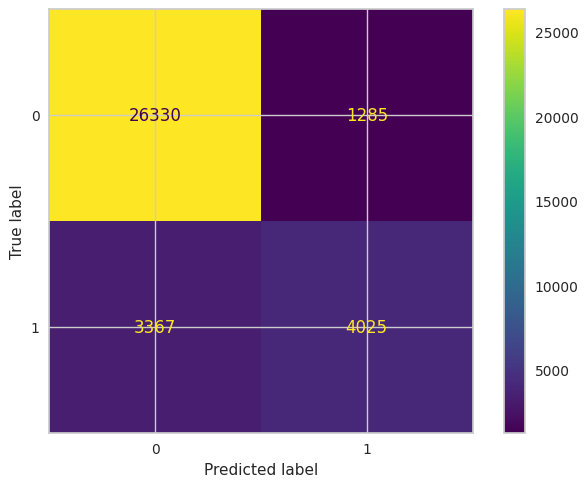

In [35]:
# preparing evaluation metric plots

y_pred = pipeline.predict(X_valid)


print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_valid, y_pred))

cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot()
plt.show()



In [36]:
auc_val = roc_auc_score(y_valid, y_pred)
print(f"           Validation ROC AUC Score: {auc_val}        ")

           Validation ROC AUC Score: 0.7489874471219529        


Validation ROC AUC Score: 0.7542534936546343        


Predictions

In [37]:
predictions= pipeline.predict_proba(test)

In [38]:
print(predictions[:,1])

[0.0272832  0.8424328  0.02501911 ... 0.02185306 0.15069762 0.12829514]


In [39]:
submission = pd.DataFrame({'id': test_data['id'], 'Exited': predictions[:,1].squeeze()})
submission.to_csv('submission.csv', index=False)

In [40]:
submission.head()

,id,Exited
0,165034,0.027283
1,165035,0.842433
2,165036,0.025019
3,165037,0.224020
4,165038,0.348766
